# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import os
import json
from pathlib import Path

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, DownloadMode

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import (
    FPKey,
    ModelKey,
    QuantStyle,
    MiscPrompts,
    Contexts,
    Texts
)

from PTQ.apply_ptq import applyPTQ
from PTQ.olmo_act_fns import patch_olmo_mlp
import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    chatbot_analysis
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import pandas as pd
from pathlib import Path

def load_metrics_from_directory(directory_path):
    all_metrics = []
    for filename in os.listdir(directory_path):
        if not filename.endswith(".json"):
            continue
        filepath = os.path.join(directory_path, filename)
        with open(filepath, 'r') as f:
            try:
                data = json.load(f)
                if isinstance(data, list) and all(isinstance(item, dict) for item in data):
                    model_id = Path(filename).stem  # Use filename as model ID
                    for item in data:
                        item['file_name'] = filename
                        item['model_id'] = model_id  # <-- set individual model_id here
                    all_metrics.extend(data)
                else:
                    print(f"[!] Unexpected structure in {filename}")
            except Exception as e:
                print(f"[!] Failed to load {filename}: {e}")
    print(f"Loaded {len(all_metrics)} total entries from {directory_path}")
    return all_metrics


"""def load_all_model_metrics(source_map): # NO DIR
    records = []

    for model_name, path in source_map.items():
        path_obj = Path(path)
        if path_obj.is_file():
            try:
                with open(path, "r") as f:
                    data = json.load(f)
                for entry in data:
                    entry['model_id'] = model_name
                    entry['file_name'] = path_obj.name
                    records.append(entry)
            except Exception as e:
                print(f"[!] Failed to load {path}: {e}")
        else:
            print(f"[!] Expected file, got directory or invalid path: {path}")

    print(f"Total entries combined: {len(records)}")
    return pd.DataFrame(records)"""



def load_all_model_metrics(source_map):
    """
    Load metrics from individual JSON files and tag with model_id and file_name.
    
    Parameters:
        source_map (dict): Mapping from model name to file path

    Returns:
        pd.DataFrame: All metrics combined and annotated
    """
    records = []

    for model_name, path in source_map.items():
        path_obj = Path(path)

        if not path_obj.is_file():
            print(f"[!] Skipping invalid path: {path}")
            continue

        try:
            with open(path_obj, "r") as f:
                data = json.load(f)

            if not isinstance(data, list) or not all(isinstance(d, dict) for d in data):
                print(f"[!] Unexpected structure in file: {path}")
                continue

            for entry in data:
                entry['model_id'] = model_name  # <- use model name from dict
                entry['file_name'] = path_obj.name  # <- actual filename
                records.append(entry)

        except Exception as e:
            print(f"[!] Failed to load {path}: {e}")

    print(f"Loaded {len(records)} total entries from {len(source_map)} files.")
    return pd.DataFrame(records)



In [3]:
model_sources_1 = {
    'OLMo-1B-hf': 'logs/gsm8k_answers/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/gsm8k_answers/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/gsm8k_answers/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/gsm8k_answers/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/gsm8k_answers/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/gsm8k_answers/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/gsm8k_answers/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/gsm8k_answers/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/gsm8k_answers/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/gsm8k_answers/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/gsm8k_answers/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/gsm8k_answers/llama.8b-1.58.fp32.json'
}

df_all_1 = load_all_model_metrics(model_sources_1)


Loaded 240 total entries from 12 files.


In [4]:
model_sources_2 = {
    'OLMo-1B-hf': 'logs/gsm8k_questions/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/gsm8k_questions/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/gsm8k_questions/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/gsm8k_questions/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/gsm8k_questions/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/gsm8k_questions/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/gsm8k_questions/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/gsm8k_questions/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/gsm8k_questions/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/gsm8k_questions/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/gsm8k_questions/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/gsm8k_questions/llama.8b-1.58.fp32.json'
}

df_all_2 = load_all_model_metrics(model_sources_2)

model_sources_3 = {
    'OLMo-1B-hf': 'logs/nq_queries/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/nq_queries/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/nq_queries/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/nq_queries/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/nq_queries/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/nq_queries/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/nq_queries/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/nq_queries/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/nq_queries/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/nq_queries/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/nq_queries/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/nq_queries/llama.8b-1.58.fp32.json'
}

df_all_3 = load_all_model_metrics(model_sources_3)

model_sources_4 = {
    'OLMo-1B-hf': 'logs/nq_answers/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/nq_answers/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/nq_answers/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/nq_answers/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/nq_answers/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/nq_answers/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/nq_answers/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/nq_answers/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/nq_answers/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/nq_answers/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/nq_answers/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/nq_answers/llama.8b-1.58.fp32.json'
}

df_all_4 = load_all_model_metrics(model_sources_4)

Loaded 240 total entries from 12 files.
Loaded 240 total entries from 12 files.
Loaded 240 total entries from 12 files.


In [26]:
df_all_1.columns

Index(['prompt', 'decoded_prompt_str', 'tokens', 'prompt_type', 'target_ids',
       'target_tokens', 'layer_names', 'correct_1', 'correct_topk',
       'correct_1_std', 'correct_topk_std', 'correct_1_by_position',
       'correct_topk_by_position', 'entropy', 'normalized_entropy',
       'logit_mean', 'prob_mean', 'stability_top1', 'stability_topk',
       'layer_kl_divergences', 'model_id', 'file_name'],
      dtype='object')

In [5]:
frames = [df_all_1, df_all_2, df_all_3, df_all_4]
df_all = pd.concat(frames)

In [28]:
print(df_all_1['model_id'].value_counts())


model_id
OLMo-1B-hf                20
OLMo-1B-8bit              20
OLMo-1B-4bit              20
OLMo-1B-1.58bit           20
DeepHermes-LLaMA-3B       20
DeepHermes-3B-8bit        20
DeepHermes-3B-4bit        20
DeepHermes-3B-1.58bit     20
LLaMA-Instruct-8B         20
LLaMA-Instruct-8B-8bit    20
LLaMA-Instruct-8B-4bit    20
HF1BitLLM                 20
Name: count, dtype: int64


In [29]:
df_all_1['prob_mean'][0]

[0.013337580487132072,
 0.00036442981217987835,
 0.0001203869323944673,
 8.025392889976501e-05,
 6.192530418047681e-05,
 6.548794044647366e-05,
 6.760304677300155e-05,
 6.572343409061432e-05,
 6.411418144125491e-05,
 6.512083928100765e-05,
 7.558174547739327e-05,
 8.367912232642993e-05,
 9.589717228664085e-05,
 0.00011229103256482631,
 0.00026762939523905516,
 0.0004646112793125212,
 0.001772050280123949]

In [6]:
df_all.head(2)

,prompt,decoded_prompt_str,tokens,prompt_type,target_ids,target_tokens,layer_names,correct_1,correct_topk,correct_1_std,...,correct_topk_by_position,entropy,normalized_entropy,logit_mean,prob_mean,stability_top1,stability_topk,layer_kl_divergences,model_id,file_name
0,"[[47, 3165, 571, 4211, 5693, 16, 19, 426, 5291...",Natalia sold 48/2 = <<48/2=24>>24 clips in May...,"[N, atal, ia, Ġsold, Ġ48, /, 2, Ġ=, Ġ<<, 48, /...",text,"[3165, 571, 4211, 5693, 16, 19, 426, 5291, 238...","[atal, ia, Ġsold, Ġ48, /, 2, Ġ=, Ġ<<, 48, /, 2...","[model.layers.0, model.layers.1, model.layers....","[1.0, 1.0, 1.0, 0.8666666666666667, 0.46666666...","[1.0, 1.0, 1.0, 1.0, 0.8, 0.4, 0.4666666666666...","[0.0, 0.0, 0.0, 0.339934634239519, 0.498887651...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,...","[10.714095115661621, 10.810699462890625, 10.81...","[[0.9322830438613892, 0.9824339747428894, 0.99...","[5.858560085296631, 2.5087482929229736, 1.5556...","[0.013337580487132072, 0.00036442981217987835,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.3021659255027771, 0.13190791010856628, 0.0...",OLMo-1B-hf,olmo.1b.fp32.json
1,"[[56, 1205, 6233, 84, 1249, 16, 1549, 426, 370...",Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,"[W, eng, Ġearn, s, Ġ12, /, 60, Ġ=, Ġ$, <<, 12,...",text,"[1205, 6233, 84, 1249, 16, 1549, 426, 370, 141...","[eng, Ġearn, s, Ġ12, /, 60, Ġ=, Ġ$, <<, 12, /,...","[model.layers.0, model.layers.1, model.layers....","[1.0, 1.0, 0.9333333333333333, 0.8, 0.53333333...","[1.0, 1.0, 0.9333333333333333, 0.8666666666666...","[0.0, 0.0, 0.24944382578492943, 0.4, 0.4988876...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...","[10.715842247009277, 10.809186935424805, 10.21...","[[0.9494099020957947, 0.9892621040344238, 0.99...","[5.693700790405273, 2.3612301349639893, 2.8372...","[0.013097528368234634, 0.00038358045276254416,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.26933687925338745, 0.04301680624485016, 0....",OLMo-1B-hf,olmo.1b.fp32.json


In [31]:
df_all.columns

Index(['prompt', 'decoded_prompt_str', 'tokens', 'prompt_type', 'target_ids',
       'target_tokens', 'layer_names', 'correct_1', 'correct_topk',
       'correct_1_std', 'correct_topk_std', 'correct_1_by_position',
       'correct_topk_by_position', 'entropy', 'normalized_entropy',
       'logit_mean', 'prob_mean', 'stability_top1', 'stability_topk',
       'layer_kl_divergences', 'model_id', 'file_name'],
      dtype='object')

In [32]:
def make_long_df(df) -> pd.DataFrame:
    # Expand prob_mean into long format
    records = []
    for _, row in df_all.iterrows():
        model_id = row['model_id']
        prob_means = row['prob_mean']
        entropy_means = row['entropy']
        logit_means = row['logit_mean']
        layers = row.get('layer_names', list(range(len(prob_means))))  # fallback to index if no names
        
        for i, (layer, mean_val) in enumerate(zip(layers, prob_means)):
            records.append({
                'model_id': model_id,
                'layer': layer,
                'layer_index': i,
                'prob_mean': mean_val,
                'entropy_mean': mean_val,
                'logits_mean': mean_val
            })

    df_long = pd.DataFrame(records)
    return df_long

In [7]:
import pandas as pd
import numpy as np

def make_long_df(df_all) -> pd.DataFrame:
    # Expand prob_mean into long format
    records = []
    for _, row in df_all.iterrows():
        model_id = row['model_id']
        prob_means = row['prob_mean']
        layers = row.get('layer_names', list(range(len(prob_means))))  # fallback to index if no names
        
        # Calculate variance of prob_mean
        prob_variance = np.var(prob_means)  # Variance of prob_mean across layers
        prob_std = np.std(prob_means)
        
        for i, (layer, mean_val) in enumerate(zip(layers, prob_means)):
            records.append({
                'model_id': model_id,
                'layer': layer,
                'layer_index': i,
                'prob_mean': mean_val,
                'prob_variance': prob_variance,
                'prob_std': prob_std,  
            })

    df_long = pd.DataFrame(records)
    return df_long


In [8]:
df_long_1 = make_long_df(df_all_1)
df_long_2 = make_long_df(df_all_2)
df_long_3 = make_long_df(df_all_3)
df_long_4 = make_long_df(df_all_4)

In [9]:
df_long = make_long_df(df_all)

In [10]:
df_long.head()

,model_id,layer,layer_index,prob_mean,prob_variance,prob_std
0,OLMo-1B-hf,model.layers.0,0,0.013338,0.00001,0.003108
1,OLMo-1B-hf,model.layers.1,1,0.000364,0.00001,0.003108
2,OLMo-1B-hf,model.layers.2,2,0.000120,0.00001,0.003108
3,OLMo-1B-hf,model.layers.3,3,0.000080,0.00001,0.003108
4,OLMo-1B-hf,model.layers.4,4,0.000062,0.00001,0.003108


In [37]:
df_all['model_id'].unique

<bound method Series.unique of 0      OLMo-1B-hf
1      OLMo-1B-hf
2      OLMo-1B-hf
3      OLMo-1B-hf
4      OLMo-1B-hf
          ...    
235     HF1BitLLM
236     HF1BitLLM
237     HF1BitLLM
238     HF1BitLLM
239     HF1BitLLM
Name: model_id, Length: 960, dtype: object>

In [38]:
import pandas as pd

# Expand prob_mean into long format
records = []
for _, row in df_all.iterrows():
    model_id = row['model_id']
    prob_means = row['prob_mean']
    entropy_means = row['entropy']
    logit_means = row['logit_mean']
    layers = row.get('layer_names', list(range(len(prob_means))))  # fallback to index if no names
    
    for i, (layer, mean_val) in enumerate(zip(layers, prob_means)):
        records.append({
            'model_id': model_id,
            'layer': layer,
            'layer_index': i,
            'prob_mean': mean_val,
            'entropy_mean': mean_val,
            'logits_mean': mean_val
        })

df_long = pd.DataFrame(records)


In [39]:
# Group by model_id and calculate the mean for the metrics (prob_mean, entropy_mean, logits_mean)
mean_values = df_long.groupby('model_id')[['prob_mean', 'entropy_mean', 'logits_mean']].mean().reset_index()

# Display the result
print(mean_values)

                  model_id  prob_mean  entropy_mean  logits_mean
0    DeepHermes-3B-1.58bit   0.964732      0.964732     0.964732
1       DeepHermes-3B-4bit   0.006449      0.006449     0.006449
2       DeepHermes-3B-8bit   0.006832      0.006832     0.006832
3      DeepHermes-LLaMA-3B   0.007037      0.007037     0.007037
4                HF1BitLLM   0.000562      0.000562     0.000562
5        LLaMA-Instruct-8B   0.002368      0.002368     0.002368
6   LLaMA-Instruct-8B-4bit   0.001911      0.001911     0.001911
7   LLaMA-Instruct-8B-8bit   0.002282      0.002282     0.002282
8          OLMo-1B-1.58bit   0.941626      0.941626     0.941626
9             OLMo-1B-4bit   0.009738      0.009738     0.009738
10            OLMo-1B-8bit   0.010268      0.010268     0.010268
11              OLMo-1B-hf   0.010333      0.010333     0.010333


In [40]:
def get_all_colmeans_round(df, decimal_places=3):
    # Group by model_id and calculate the mean for the metrics (prob_mean, entropy_mean, logits_mean)
    mean_values = df.groupby('model_id')[['prob_mean', 'entropy_mean', 'logits_mean']].mean().reset_index()

    # Round the values to the specified number of decimal places
    mean_values = mean_values.round({'prob_mean': decimal_places, 
                                     'entropy_mean': decimal_places, 
                                     'logits_mean': decimal_places})

    # Display the result
    print(mean_values)


In [11]:
def get_all_colmeans_round_2(df, decimal_places=6):
    # Group by model_id and calculate the mean for the metrics (prob_mean, entropy_mean, logits_mean)
    mean_values = df.groupby('model_id')[['prob_mean', 'prob_variance', 'prob_std']].mean().reset_index()

    # Round the values to the specified number of decimal places
    mean_values = mean_values.round({'prob_mean': decimal_places, 
                                     'prob_variance': decimal_places,
                                     'prob_std': decimal_places})

    # Display the result
    print(mean_values)

In [42]:
def get_all_colmeans(df):
    # Group by model_id and calculate the mean for the metrics (prob_mean, entropy_mean, logits_mean)
    mean_values = df.groupby('model_id')[['prob_mean', 'entropy_mean', 'logits_mean']].mean().reset_index()

    # Display the result
    print(mean_values)

In [12]:
get_all_colmeans_round_2(df_long, decimal_places=6) # all

                  model_id  prob_mean  prob_variance  prob_std
0    DeepHermes-3B-1.58bit   0.964732       0.033259  0.182370
1       DeepHermes-3B-4bit   0.006449       0.000700  0.024772
2       DeepHermes-3B-8bit   0.006832       0.000766  0.025868
3      DeepHermes-LLaMA-3B   0.007037       0.000816  0.026763
4                HF1BitLLM   0.000562       0.000003  0.001193
5        LLaMA-Instruct-8B   0.002368       0.000096  0.008599
6   LLaMA-Instruct-8B-4bit   0.001911       0.000072  0.007310
7   LLaMA-Instruct-8B-8bit   0.002282       0.000088  0.008270
8          OLMo-1B-1.58bit   0.941626       0.054293  0.233004
9             OLMo-1B-4bit   0.009738       0.000089  0.006250
10            OLMo-1B-8bit   0.010268       0.000085  0.006153
11              OLMo-1B-hf   0.010333       0.000086  0.006164


findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family ['Noto Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'Noto Sans' not found.
findfont: Font family 'N

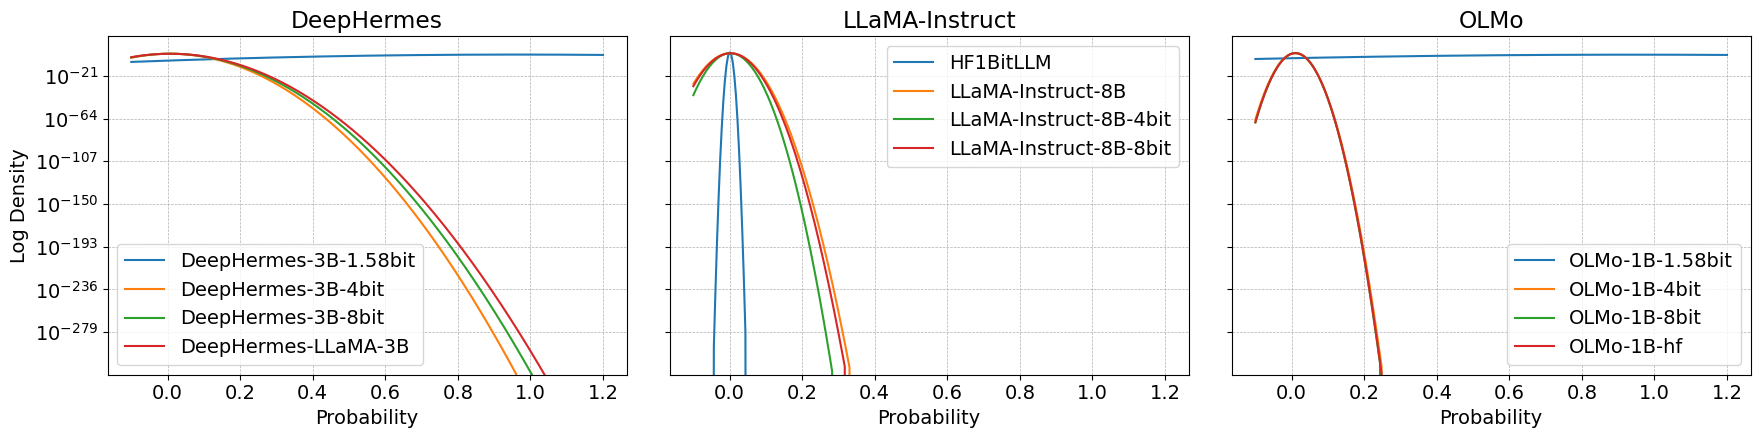

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Your data
data = df_long

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Your real data
data = pd.DataFrame({
    'model_id': [
        'DeepHermes-3B-1.58bit', 'DeepHermes-3B-4bit', 'DeepHermes-3B-8bit', 'DeepHermes-LLaMA-3B',
        'HF1BitLLM', 'LLaMA-Instruct-8B', 'LLaMA-Instruct-8B-4bit', 'LLaMA-Instruct-8B-8bit',
        'OLMo-1B-1.58bit', 'OLMo-1B-4bit', 'OLMo-1B-8bit', 'OLMo-1B-hf'
    ],
    'prob_mean': [
        0.964732, 0.006449, 0.006832, 0.007037,
        0.000562, 0.002368, 0.001911, 0.002282,
        0.941626, 0.009738, 0.010268, 0.010333
    ],
    'prob_std': [
        0.182370, 0.024772, 0.025868, 0.026763,
        0.001193, 0.008599, 0.007310, 0.008270,
        0.233004, 0.006250, 0.006153, 0.006164
    ]
})

# Explicit family map (no guessing)
model_families = {
    'DeepHermes-3B-1.58bit': 'DeepHermes',
    'DeepHermes-3B-4bit': 'DeepHermes',
    'DeepHermes-3B-8bit': 'DeepHermes',
    'DeepHermes-LLaMA-3B': 'DeepHermes',
    'HF1BitLLM': 'LLaMA-Instruct',
    'LLaMA-Instruct-8B': 'LLaMA-Instruct',
    'LLaMA-Instruct-8B-4bit': 'LLaMA-Instruct',
    'LLaMA-Instruct-8B-8bit': 'LLaMA-Instruct',
    'OLMo-1B-1.58bit': 'OLMo',
    'OLMo-1B-4bit': 'OLMo',
    'OLMo-1B-8bit': 'OLMo',
    'OLMo-1B-hf': 'OLMo'
}

data["model_type"] = data["model_id"].map(model_families)

# Final safety check
if data["model_type"].isnull().any():
    raise ValueError("Some models weren't classified. Fix model_families dictionary.")

# Plot setup
plt.rcParams['font.family'] = 'Noto Sans'
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
x = np.linspace(-0.1, 1.2, 300)
model_types = ["DeepHermes", "LLaMA-Instruct", "OLMo"]

for ax, model_type in zip(axes, model_types):
    subset = data[data["model_type"] == model_type]
    
    for _, row in subset.iterrows():
        mu, std = row["prob_mean"], row["prob_std"]
        if std <= 0:
            continue
        y = norm.pdf(x, mu, std)
        ax.plot(x, y, label=row["model_id"])

    ax.set_title(model_type)
    ax.set_xlabel("Probability")
    ax.set_yscale("log")  # ← LOG SCALE FOR VISIBILITY
    ax.legend(fontsize=14)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

axes[0].set_ylabel("Log Density")
#plt.suptitle("Normal Distributions (Log Scale for Visibility)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Outputs/ProbsDistribs/log_probs_2.jpg", dpi=300, bbox_inches='tight')
plt.show()


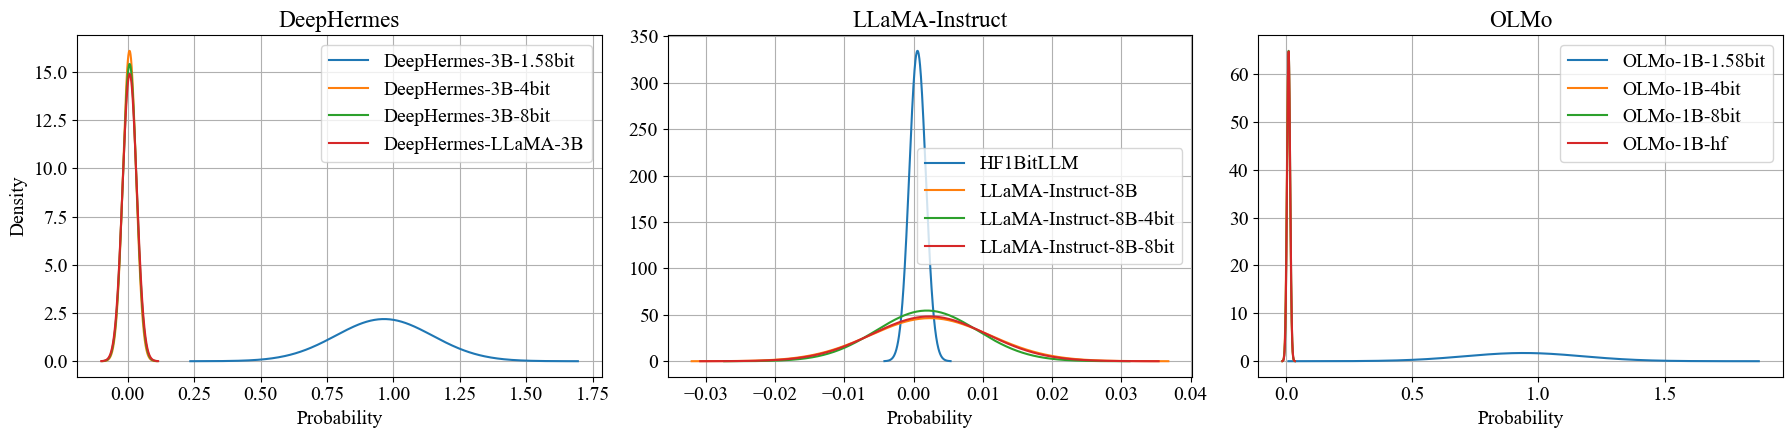

In [25]:
# Create plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

model_types = ["DeepHermes", "LLaMA-Instruct", "OLMo"]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

for ax, model_type in zip(axes, model_types):
    subset = data[data["model_type"] == model_type]

    for _, row in subset.iterrows():
        mean = row["prob_mean"]
        std = row["prob_std"]

        if std <= 0:
            continue

        # Centered x-range for each curve
        x = np.linspace(mean - 4*std, mean + 4*std, 300)
        y = norm.pdf(x, mean, std)

        ax.plot(x, y, label=row["model_id"])

    ax.set_title(model_type)
    ax.set_xlabel("Probability")
    ax.grid(True)
    ax.legend(fontsize=14)

axes[0].set_ylabel("Density")
#plt.suptitle("Correct Full Normal Distributions for Model Versions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Outputs/ProbsDistribs/normal_distributions_ptsq.jpg", dpi=300, bbox_inches='tight')
plt.show()

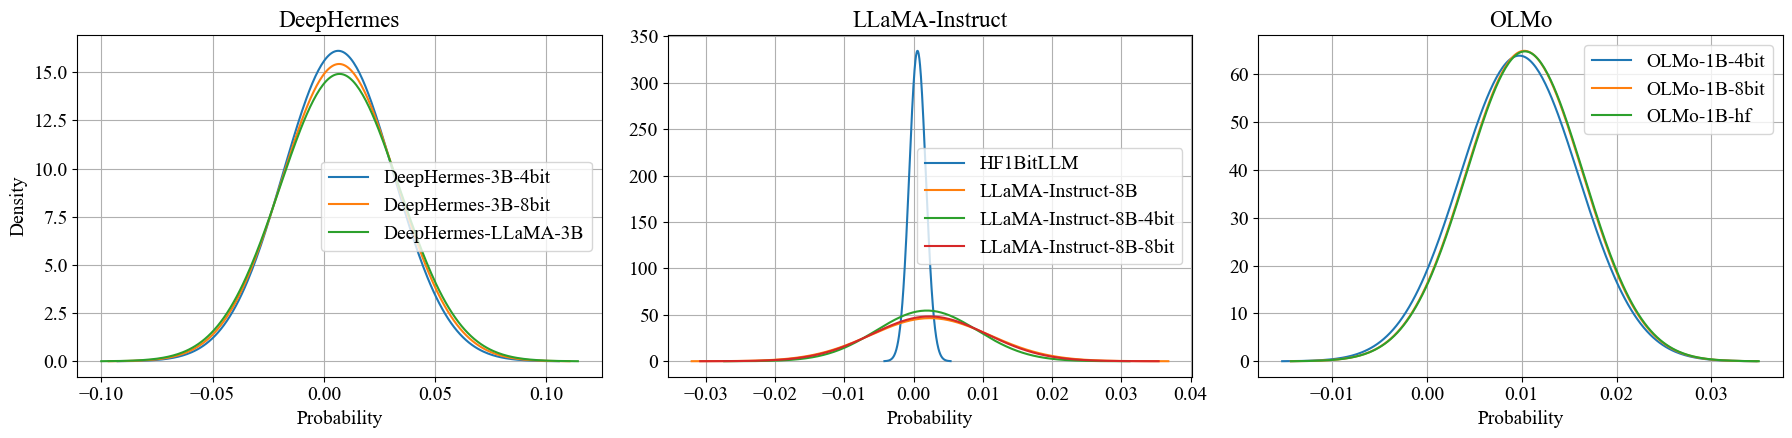

In [24]:
outliers_to_remove = ["DeepHermes-3B-1.58bit", "OLMo-1B-1.58bit"]
data_filtered = data[~data["model_id"].isin(outliers_to_remove)]

# Plot setup
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
model_types = ["DeepHermes", "LLaMA-Instruct", "OLMo"]

for ax, model_type in zip(axes, model_types):
    subset = data_filtered[data_filtered["model_type"] == model_type]

    for _, row in subset.iterrows():
        mean = row["prob_mean"]
        std = row["prob_std"]

        if std <= 0:
            continue

        x = np.linspace(mean - 4*std, mean + 4*std, 300)
        y = norm.pdf(x, mean, std)
        ax.plot(x, y, label=row["model_id"])

    ax.set_title(model_type)
    ax.set_xlabel("Probability")
    ax.grid(True)
    ax.legend(fontsize=14)

axes[0].set_ylabel("Density")
#plt.suptitle("Normal Distributions Without 1.58-bit Outliers", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Outputs/ProbsDistribs/normal_distributions_clean.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
data['prob_std']

0     0.182370
1     0.024772
2     0.025868
3     0.026763
4     0.001193
5     0.008599
6     0.007310
7     0.008270
8     0.233004
9     0.006250
10    0.006153
11    0.006164
Name: prob_std, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.DataFrame(df_long)

# Add model group
df['group'] = df['model_id'].apply(
    lambda x: 'DeepHermes' if 'DeepHermes' in x else 
              'LLaMA-Instruct' if 'LLaMA-Instruct' in x or 'HF1BitLLM' in x else 
              'OLMo'
)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
groups = df['group'].unique()
markers = {
    '4bit': 'o', '8bit': 's', 'hf': 'D', 'FP': '^', '1.58bit': '*'
}

for i, group in enumerate(groups):
    sub_df = df[df['group'] == group]
    ax = axs[i]
    
    for _, row in sub_df.iterrows():
        mean = row['prob_mean']
        std = np.sqrt(row['prob_variance'])
        x = np.linspace(mean - 3*std, mean + 3*std, 100)
        y = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2))
        
        label = row['model_id']
        if '1.58bit' in label:
            marker = markers['1.58bit']
        elif '4bit' in label:
            marker = markers['4bit']
        elif '8bit' in label:
            marker = markers['8bit']
        elif 'hf' in label:
            marker = markers['hf']
        else:
            marker = markers['FP']
        
        ax.plot(x, y, marker=marker, markevery=[50], label=label)

    ax.set_title(group, fontsize=12)
    ax.set_xlabel("Probability", fontsize=11)
    if i == 0:
        ax.set_ylabel("Density", fontsize=11)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = df_long

# Split data by model group
groups = {
    "DeepHermes": df[df["model_id"].str.contains("DeepHermes")],
    "LLaMA-Instruct + HF1BitLLM": df[df["model_id"].str.contains("LLaMA-Instruct|HF1BitLLM")],
    "OLMo": df[df["model_id"].str.contains("OLMo")]
}

# Define markers
markers = {
    "1.58bit": "o",
    "4bit": "s",
    "8bit": "^",
    "hf": "P",
    "default": "D"
}

# Plot the Gaussian curves
x_vals = np.linspace(-0.05, 0.05, 1000)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, (group_name, group_df) in zip(axs, groups.items()):
    for _, row in group_df.iterrows():
        mean = row["prob_mean"]
        var = row["prob_variance"]
        std = np.sqrt(var)
        if std == 0:
            continue
        x = np.linspace(mean - 4*std, mean + 4*std, 1000)
        y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)
        label = row["model_id"]
        # Determine marker
        bit_key = next((key for key in markers if key in label), "default")
        ax.plot(x, y, marker=markers[bit_key], markevery=200, label=label, linewidth=1.5)

    ax.set_title(group_name, fontsize=14, fontfamily="serif")
    ax.set_xlabel("Probability", fontsize=12, fontfamily="serif")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(fontsize=9)

axs[0].set_ylabel("Density", fontsize=12, fontfamily="serif")
fig.suptitle("Gaussian-Approximated Probability Distributions Across Models", fontsize=16, fontfamily="serif")
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font globally
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']

# Data
data = df_long
# Model type mapping
def extract_model_family(name):
    if "OLMo" in name:
        return "OLMo"
    elif "DeepHermes" in name:
        return "DeepHermes"
    elif "LLaMA-Instruct" in name or "HF1BitLLM" in name:
        return "LLaMA"
    return "Other"

data['family'] = data['model_id'].apply(extract_model_family)

# Marker map
marker_map = {
    '4bit': 'o',
    '8bit': 's',
    '1.58bit': '^',
    'hf': 'X',
    'LLaMA-Instruct-8B': 'P',
    'DeepHermes-LLaMA-3B': 'D',
}

def get_marker(model_id):
    for key in marker_map:
        if key in model_id:
            return marker_map[key]
    return 'v'

data['marker'] = data['model_id'].apply(get_marker)

# X-range for plotting
x = np.linspace(0, 1, 500)

def plot_distribution(ax, group_data, normalize=False, log_y=False):
    for _, row in group_data.iterrows():
        mean = row['prob_mean']
        var = row['prob_variance']
        std = np.sqrt(var)
        label = row['model_id']
        marker = row['marker']
        y = np.exp(-0.5 * ((x - mean) / std)**2)
        if normalize:
            y /= y.max()
        ax.plot(x, y, label=label, marker=marker, markevery=50)

    ax.set_title(group_data['family'].iloc[0])
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    if log_y:
        ax.set_yscale('log')
    ax.legend(fontsize=8)

# Plot A: WITH ALL MODELS INCLUDING 1.58-bit (y-axis normalized)
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
for i, (fam, group) in enumerate(data.groupby('family')):
    plot_distribution(axs[i], group, normalize=True, log_y=False)
fig.suptitle("Probability Distribution Curves (All Models Included)")
plt.tight_layout()
plt.show()

# Plot B: EXCLUDING OLMo and DeepHermes 1.58-bit models
exclude_ids = ['DeepHermes-3B-1.58bit', 'OLMo-1B-1.58bit']
data_filtered = data[~data['model_id'].isin(exclude_ids)]

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
for i, (fam, group) in enumerate(data_filtered.groupby('family')):
    plot_distribution(axs[i], group, normalize=False, log_y=False)
fig.suptitle("Probability Distribution Curves (Excluding Some 1.58-bit Models)")
plt.tight_layout()
plt.show()


In [ ]:
# 1 = gsm8k answer and 2 = questions, 3 = NQ queries and 4 = answer

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = df_long

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define groups
group1 = df[:4]
group2 = df[4:8]
group3 = df[8:]

# Helper function to plot a line for each model
def plot_model_distribution(ax, group, color, label, marker):
    x = np.linspace(0, 1, 100)  # X-axis range for the distribution
    for _, row in group.iterrows():
        mean = row['prob_mean']
        var = row['prob_variance']
        # Create a normal distribution with the given mean and variance
        dist = np.random.normal(mean, np.sqrt(var), 1000)
        
        # Plot the line
        sns.kdeplot(dist, ax=ax, color=color, label=label, linestyle='-', marker=marker, lw=2)
        
# Plot each group
# Group 1
plot_model_distribution(axs[0], group1, 'blue', 'Group 1', 'o')

# Group 2
plot_model_distribution(axs[1], group2, 'green', 'Group 2', 's')

# Group 3
plot_model_distribution(axs[2], group3, 'red', 'Group 3', 'D')

# Set the title and labels
axs[0].set_title('Model Distributions for Group 1')
axs[1].set_title('Model Distributions for Group 2')
axs[2].set_title('Model Distributions for Group 3')

# Set x and y axis labels
for ax in axs:
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
get_all_colmeans_round(df_long_1) # 1 = gsm8k answer

In [ ]:
get_all_colmeans_round(df_long_2) # 2 = gsm8k question

In [ ]:
get_all_colmeans_round(df_long_3) # 3 = NQ query

In [ ]:
get_all_colmeans_round(df_long_4) # 4 = NQ answer

In [ ]:
# Assuming you have a list of dataframes for different datasets
datasets = [df_long_1, df_long_2, df_long_3, df_long_4, df_long]  # Replace with your actual list of dataframes
results = []

for dataset in datasets:
    mean_values = dataset.groupby('model_id')[['prob_mean', 'entropy_mean', 'logits_mean']].mean().reset_index()
    results.append(mean_values)

# If you want to merge them into one dataframe for easy comparison
final_results = pd.concat(results, ignore_index=True)

# Display the final result
print(final_results)


In [ ]:
df_all_1['model_id']

In [ ]:
df_all_1['correct_1']

In [ ]:
df_all_1['layer_names']

In [ ]:
for i in df_all_1['correct_1']:
    print(sum(i)/len(i))

In [ ]:
records = []
for _, row in df_all.iterrows():
    model_id = row['model_id']
    prob_means = row['prob_mean']
    layers = row.get('layer_names', list(range(len(prob_means))))  # fallback to index if needed

    for i, (layer, prob) in enumerate(zip(layers, prob_means)):
        records.append({
            'model_id': model_id,
            'layer_index': i,
            'prob_mean': prob
        })

df_long = pd.DataFrame(records)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data frame setup (based on the description)
# Assuming df is the dataframe with the columns: model_id, correct_1, layer_names
# Each "correct_1" and "layer_names" column is a list for each model

def plot_correct(df, save_name, metric='stability_top1') -> None:
    # Step 1: Expand each model's correct_1 and layer_names into individual rows
    expanded_rows = []

    for i, row in df.iterrows():
        model_id = row['model_id']
        correct_1 = row[metric]
        layer_names = row['layer_names']
        
        # Align correct_1 with layer_names (flatten the lists)
        for layer, score in zip(layer_names, correct_1):
            expanded_rows.append({'model_id': model_id, 'layer_name': layer, metric: score})

    # Convert expanded data into a new DataFrame
    expanded_df = pd.DataFrame(expanded_rows)

    # Step 2: Create a bar plot for each layer comparing the correct_1 scores across models
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(14, 8))

    # Group the data by layer_name and plot the correct_1 scores for each model
    sns.lineplot(data=expanded_df, x='layer_name', y=metric, hue='model_id')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, ha='right')

    #plt.title('Correct_1 Scores by Layer for Each Model', fontsize=16)
    plt.xlabel('Layer Name', fontsize=12)
    plt.ylabel('Correct_1 Score', fontsize=12)
    plt.legend(title='Model ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save or display the plot
    plt.savefig(save_name)
    plt.show()


In [ ]:
df_all.columns

In [ ]:
plot_correct(df_all, 'Outputs/all_datasets/correct_topk_std.jpg', metric='correct_topk_std')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance

# Normalize all prob_mean vectors per model
df_long['prob_mean_norm'] = df_long.groupby('model_id')['prob_mean'].transform(
    lambda x: x / x.sum() if x.sum() > 0 else x
)

# Define base and quantized models
all_models = df_long['model_id'].unique()
quantized_models = [m for m in all_models if 'bit' in m or 'Bit' in m]

# Manual fallback mapping for non-patterned models like HF1BitLLM
custom_base_mapping = {
    'HF1BitLLM': 'LLaMA-Instruct-8B',
}

def find_base_model(quant_model):
    # Check manual overrides first
    if quant_model in custom_base_mapping:
        return custom_base_mapping[quant_model]

    # Remove "-8bit", "-4bit", "-1.58bit", etc.
    stripped = quant_model
    for suffix in ['-8bit', '-4bit', '-1.58bit', '-ptsq', '-bnb8bit', '-bnb4bit']:
        if quant_model.endswith(suffix):
            stripped = quant_model.replace(suffix, '')
            break

    # Look for exact match or close match
    for base in all_models:
        if base == stripped or base.lower().startswith(stripped.lower()):
            return base
    return None

plt.rcParams['font.family'] = 'Times New Roman'
# 3x3 grid
n_cols = 3
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

for i, model in enumerate(quantized_models):
    ax = axes[i]
    base_model = find_base_model(model)

    if base_model is None or base_model not in df_long['model_id'].values:
        ax.set_title(f"No match for {model}")
        ax.axis('off')
        continue

    base_data = df_long[df_long['model_id'] == base_model]['prob_mean_norm'].sort_values().reset_index(drop=True)
    comp_data = df_long[df_long['model_id'] == model]['prob_mean_norm'].sort_values().reset_index(drop=True)

    min_len = min(len(base_data), len(comp_data))
    x = base_data[:min_len]
    y = comp_data[:min_len]

    reference = np.random.permutation(np.concatenate([x, y]))
    w_dist = wasserstein_distance(x, y)
    norm = max(
        wasserstein_distance(x, reference[:min_len]),
        wasserstein_distance(y, reference[:min_len])
    )
    nwd = w_dist / norm if norm != 0 else 0

    ax.scatter(x, y, s=20, alpha=0.7)
    ax.plot([0, max(x.max(), y.max())], [0, max(x.max(), y.max())], 'r--')
    ax.set_title(f"{model} vs.\n{base_model}\nNWD = {nwd:.3f}", fontsize=12)
    ax.set_xlabel(base_model)
    ax.set_ylabel(model)
    ax.grid(True)

# Clean up unused plots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Q-Q Plots: Quantized vs. Base Models (NWD)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Outputs/all_datasets/qq_plot_nwd_quant_vs_fp_fixedgrid_all_datasets.jpg')
plt.show()


In [ ]:
reference_model = 'OLMo-1B-hf'  # baseline
model_order = (
    df_distances[df_distances['model_1'] == reference_model]
    .sort_values('wasserstein')['model_2']
    .tolist()
)
model_order = [reference_model] + [m for m in model_order if m != reference_model]


In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, leaves_list


model_ids = sorted(model_vectors.keys())
distance_matrix = np.zeros((len(model_ids), len(model_ids)))

for i, m1 in enumerate(model_ids):
    for j, m2 in enumerate(model_ids):
        if i < j:
            d = wasserstein_distance(pad_vector(model_vectors[m1]), pad_vector(model_vectors[m2]))
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d


Z = linkage(squareform(distance_matrix), method='ward')
ordered_indices = leaves_list(Z)
model_order = [model_ids[i] for i in ordered_indices]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_palette = sns.color_palette("tab20", n_colors=df_long['model_id'].nunique())

plt.figure(figsize=(18, 6))
plt.rcParams['font.family'] = 'Times New Roman'
sns.violinplot(
    data=df_long,
    x='model_id',
    y='prob_mean',
    palette=model_palette,
    inner=None,
    cut=0,
    linewidth=1.2
)

norm = plt.Normalize(df_long['layer_index'].min(), df_long['layer_index'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
layer_colors = sm.to_rgba(df_long['layer_index'])

sns.stripplot(
    data=df_long,
    x='model_id',
    y='prob_mean',
    hue='layer_index',
    palette="coolwarm",
    size=3,
    jitter=True,
    dodge=False,
    alpha=0.8,
    linewidth=0
)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("Mean Probability per Layer")
plt.title("Layer-wise Mean Probabilities per Model (Colored by Layer Index)")

handles, labels = plt.gca().get_legend_handles_labels()
n = df_long['layer_index'].nunique()
plt.legend(handles[-n:], labels[-n:], title='Layer Index', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
#plt.savefig('Outputs/all_datasets/boxplot_layerprobs_all_datasets.jpg')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

unique_models = df_long['model_id'].unique()
n_models = len(unique_models)

n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

for i, model in enumerate(unique_models):
    ax = axes[i]
    model_data = df_long[df_long['model_id'] == model]['prob_mean'].dropna()

    stats.probplot(model_data, dist="norm", plot=ax)
    ax.set_title(model, fontsize=12)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Q-Q Plots of Layer-wise Probabilities per Model", fontsize=16, y=1.02)
plt.savefig('Outputs/all_datasets/qq_plot_layerprobs_all_datasets.jpg')
plt.show()


In [ ]:
model_a = 'LLaMA-Instruct-8B'
model_b = 'HF1BitLLM'


data_a = df_long[df_long['model_id'] == model_a]['prob_mean'].sort_values().reset_index(drop=True)
data_b = df_long[df_long['model_id'] == model_b]['prob_mean'].sort_values().reset_index(drop=True)

min_len = min(len(data_a), len(data_b))

plt.figure(figsize=(6,6))
plt.plot(data_a[:min_len], data_b[:min_len], 'o')
plt.plot([0, max(data_a.max(), data_b.max())], [0, max(data_a.max(), data_b.max())], 'r--')
plt.xlabel(model_a)
plt.ylabel(model_b)
plt.title(f"Q-Q Plot: {model_a} vs. {model_b}")
plt.grid(True)
plt.tight_layout()
plt.savefig('Outputs/gsm8k_answers/qq_xllama_yhf1bitllmplot_layerprobs_gsm8k_answers.jpg')
plt.show()


In [ ]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Reshape to {model_id: [prob_mean values]}
model_probs = df_long.groupby('model_id')['prob_mean'].apply(list).to_dict()

# Build distance matrix
model_ids = list(model_probs.keys())
n_models = len(model_ids)
nwd_matrix = np.zeros((n_models, n_models))

# Use standard normal or uniform reference distribution for normalization
# Here we use the union of all values as a reference
all_values = np.concatenate(list(model_probs.values()))
reference = np.random.permutation(all_values)

for i, model_i in enumerate(model_ids):
    for j, model_j in enumerate(model_ids):
        if i >= j:
            continue  # matrix is symmetric
        a = np.array(model_probs[model_i])
        b = np.array(model_probs[model_j])

        # Match lengths if needed
        min_len = min(len(a), len(b))
        a, b = a[:min_len], b[:min_len]

        # Wasserstein distance
        w_dist = wasserstein_distance(a, b)

        # Normalize
        norm = max(
            wasserstein_distance(a, reference[:min_len]),
            wasserstein_distance(b, reference[:min_len])
        )
        nwd = w_dist / norm if norm != 0 else 0

        # Fill matrix (symmetrically)
        nwd_matrix[i, j] = nwd
        nwd_matrix[j, i] = nwd

# Turn into DataFrame for plotting
nwd_df = pd.DataFrame(nwd_matrix, index=model_ids, columns=model_ids)

# Plot as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(nwd_df, cmap="coolwarm", annot=True, fmt=".2f", square=True)
plt.title("Normalized Wasserstein Distance Between Models (Layer-wise Probabilities)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance

# --- 1. Preprocess df_all['layer_names'] ---
# Ensure each row of df_all has a list of layer names
df_all = df_all_1.copy()

# If entries are strings, safely evaluate them
df_all['layer_names'] = df_all['layer_names'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

# Explode df_all into one row per layer, with normalized prob_mean
records = []
for _, row in df_all.iterrows():
    model_id = row['model_id']
    layer_names = row['layer_names']
    prob_means = row['prob_mean']

    # 🔹 Normalize over total (vocab) size
    prob_means = np.array(prob_means)
    if prob_means.sum() > 0:
        prob_means = prob_means / prob_means.sum()

    for idx, prob in enumerate(prob_means):
        layer_name = layer_names[idx] if idx < len(layer_names) else f"layer_{idx}"
        records.append({
            'model_id': model_id,
            'layer_idx': idx,
            'prob_mean': prob,
            'layer_name': layer_name
        })

df_long = pd.DataFrame.from_records(records)



# --- 4. Group by layer_name and compute NWD matrices ---
grouped = df_long.groupby('layer_name')
n_layers = len(grouped)
n_cols = 4
n_rows = int(np.ceil(n_layers / n_cols))

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4.5))
axes = axes.flatten()

for i, (layer_name, group) in enumerate(grouped):
    ax = axes[i]
    
    # Get per-model list of probs for this layer
    model_probs = group.groupby('model_id')['prob_mean'].apply(list).to_dict()
    model_ids = list(model_probs.keys())
    n_models = len(model_ids)
    
    if n_models < 2:
        ax.axis('off')
        continue

    # Compute reference distribution
    all_values = np.concatenate(list(model_probs.values()))
    reference = np.random.permutation(all_values)

    # Compute NWD matrix
    nwd_matrix = np.zeros((n_models, n_models))
    for m, model_i in enumerate(model_ids):
        for n, model_j in enumerate(model_ids):
            if m >= n:
                continue
            a = np.array(model_probs[model_i])
            b = np.array(model_probs[model_j])
            min_len = min(len(a), len(b))
            a, b = a[:min_len], b[:min_len]
            w_dist = wasserstein_distance(a, b)
            norm = max(
                wasserstein_distance(a, reference[:min_len]),
                wasserstein_distance(b, reference[:min_len])
            )
            nwd = w_dist / norm if norm != 0 else 0
            nwd_matrix[m, n] = nwd
            nwd_matrix[n, m] = nwd

    # Plot heatmap
    nwd_df = pd.DataFrame(nwd_matrix, index=model_ids, columns=model_ids)
    sns.heatmap(nwd_df, ax=ax, cmap="coolwarm", annot=True, fmt=".2f",  square=True, cbar=False,
                xticklabels=False, yticklabels=False)
    ax.set_title(layer_name, fontsize=16)

# --- 5. Clean up layout ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Normalized Wasserstein Distances Per Layer", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Outputs/all_datasets/nwd_layerwise_heatmap_layerprobs_normalized_gsm8kanswer_all_datasets.jpg')
plt.show()


In [ ]:
df_all['model_id'].unique()

In [ ]:
df_all.head()

In [ ]:
len(df_all['prob_mean'][0])

In [ ]:
print(df_all['model_id'].value_counts())
print(df_all.columns)


In [ ]:
# Show random sample
print(df_all.sample(10)[['model_id', 'file_name']])

# Or show top N unique combinations
print(df_all[['model_id', 'file_name']].drop_duplicates().head(12))


In [ ]:
# Ensure your plotting DataFrame is grouped correctly
grouped = df_all.groupby("model_id")
for name, group in grouped:
    print(f"{name}: {len(group)} rows")


In [ ]:
def flatten_singleton_lists(df, columns):
    """
    Replace singleton lists (e.g., [0.5]) with scalar values in specified columns.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
    return df


In [ ]:
singleton_cols = ['entropy', 'normalized_entropy', 'logit_mean', 'prob_mean',
                  'stability_top1', 'stability_topk']  # Add others if needed

df_all = flatten_singleton_lists(df_all, singleton_cols)


In [ ]:
singleton_cols = ['prompt', 'decoded_prompt_str', 'tokens', 'prompt_type', 'target_ids',
       'target_tokens', 'layer_names', 'correct_1', 'correct_topk',
       'correct_1_std', 'correct_topk_std', 'correct_1_by_position',
       'correct_topk_by_position', 'entropy', 'normalized_entropy',
       'logit_mean', 'prob_mean', 'stability_top1', 'stability_topk',
       'layer_kl_divergences', 'model_id', 'file_name']  # Add others if needed

df_all = flatten_singleton_lists(df_all, singleton_cols)

In [ ]:
df_all['kl_layer_last'] = df_all['layer_kl_divergences'].apply(lambda x: x[-1] if isinstance(x, list) else np.nan)
df_all['kl_layer_mean'] = df_all['layer_kl_divergences'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)


In [ ]:
df_all['logit_std'] = df_all['logit_mean'].apply(np.std)

In [ ]:
# Only select needed columns
sub_df = df_all[['model_id', 'layer_names', 'correct_1_by_position']].copy()

# Sanity filter: only keep rows where lengths match
sub_df = sub_df[sub_df['layer_names'].str.len() == sub_df['correct_1_by_position'].str.len()]

# Repeat model_id per layer
sub_df = sub_df.explode(['layer_names', 'correct_1_by_position'])

# Rename for clarity
sub_df = sub_df.rename(columns={'layer_names': 'layer_name', 'correct_1_by_position': 'correct_1'})


In [ ]:
import itertools

def flatten_nested(l):
    return list(itertools.chain.from_iterable(l)) if isinstance(l[0], list) else l

df['layer_names'] = df['layer_names'].apply(flatten_nested)
df['correct_1_by_position'] = df['correct_1_by_position'].apply(flatten_nested)


In [ ]:
# Check shapes
print("Original shape:", df_all.shape)

# Show sample raw values
print("\nSample layer_names:", df_all['layer_names'].iloc[0])
print("Sample correct_1_by_position:", df_all['correct_1_by_position'].iloc[0])
print("Type layer_names:", type(df_all['layer_names'].iloc[0]))
print("Type correct_1_by_position:", type(df_all['correct_1_by_position'].iloc[0]))

# Show lengths (if list-like)
print("\nLength of layer_names:", len(df_all['layer_names'].iloc[0]) if isinstance(df_all['layer_names'].iloc[0], list) else 'not list')
print("Length of correct_1_by_position:", len(df_all['correct_1_by_position'].iloc[0]) if isinstance(df_all['correct_1_by_position'].iloc[0], list) else 'not list')


In [ ]:
# Aggregate nested lists to their mean per layer
df_all['correct_1_mean_by_layer'] = df_all['correct_1_by_position'].apply(
    lambda layer_preds: [sum(layer)/len(layer) if len(layer) > 0 else 0 for layer in layer_preds]
)


In [ ]:
print("Length layer_names:", len(df_all['layer_names'].iloc[0]))
print("Length correct_1_mean_by_layer:", len(df_all['correct_1_mean_by_layer'].iloc[0]))


In [ ]:
# Aggregate nested lists to their mean per layer
df_all['kl_divergences_mean_by_layer'] = df_all['layer_kl_divergences'].apply(
    lambda layer_preds: [sum(layer)/len(layer) if len(layer) > 0 else 0 for layer in layer_preds]
)

In [ ]:
sub_df = df_all[['model_id', 'layer_names', 'correct_1_mean_by_layer']].copy()

# Make sure lengths match, else truncate
def truncate_lists(row):
    min_len = min(len(row['layer_names']), len(row['correct_1_mean_by_layer']))
    return pd.Series({
        'model_id': row['model_id'],
        'layer_names': row['layer_names'][:min_len],
        'correct_1_mean_by_layer': row['correct_1_mean_by_layer'][:min_len]
    })

sub_df = sub_df.apply(truncate_lists, axis=1)

# Explode both list columns
sub_df = sub_df.explode(['layer_names', 'correct_1_mean_by_layer'])

sub_df = sub_df.rename(columns={
    'layer_names': 'layer_name',
    'correct_1_mean_by_layer': 'correct_1'
})

# Optional: extract numeric layer index for plotting
sub_df['layer_num'] = sub_df['layer_name'].str.extract(r'(\d+)$').astype(int)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.lineplot(
    data=sub_df,
    x='layer_num',
    y='correct_1',
    hue='model_id',
    marker='o',
    linestyle='-',
    markersize=6,
    linewidth=2
)

plt.xlabel("Layer")
plt.ylabel("Mean Correct@1 per Layer")
plt.title("Mean Correct@1 per Layer by Model")

plt.grid(True)

# Optionally set x-limits to max max layer_num across models to keep same scale
max_layer = sub_df['layer_num'].max()
plt.xlim(0, max_layer + 1)

plt.tight_layout()
plt.savefig('mean_correct1_by_layer')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '8']  # extend if needed

# Get unique models
models = sub_df['model_id'].unique()

for i, model in enumerate(models):
    marker = markers[i % len(markers)]
    model_data = sub_df[sub_df['model_id'] == model]
    plt.plot(
        model_data['layer_num'],
        model_data['correct_1'],
        marker=marker,
        label=model,
        linewidth=2,
        markersize=8
    )

plt.xlabel("Layer")
plt.ylabel("Mean Correct@1 per Layer")
plt.title("Mean Correct@1 per Layer by Model")

plt.grid(True)
plt.legend(title='Model ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: extract numeric layer index
sub_df['layer_num'] = sub_df['layer_name'].str.extract(r'(\d+)$').astype(int)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=sub_df, x='layer_num', y='correct_1', hue='model_id', marker='o')
plt.xlabel("Layer")
plt.ylabel("Correct@1")
plt.title("Correct@1 per Layer by Model")
plt.grid(True)
plt.tight_layout()
plt.show()


## Language and Cosine

In [ ]:
from scipy.spatial.distance import cosine

def compute_cosine_similarity_per_position(probs1, probs2):
    return [1 - cosine(p1, p2) if not (np.all(p1 == 0) or np.all(p2 == 0)) else 0.0
            for p1, p2 in zip(probs1, probs2)]


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42  # ensure consistent results

#df_all['language'] = df_all['decoded_prompt_str'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
#df_all['language'] = df_all['tokens'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
df_all['language'] = df_all['target_tokens'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')


In [ ]:
for w in df_all['language']:
    if w != 'en':
        print(w)

In [ ]:
df_all.columns

In [ ]:
metrics_config = [
    #("prob_mean", "e) Mean Prob of TopK", "Mean Prob."),
    ("logit_mean", "a) Mean Logit Magnitude", "Mean Logit"),
    ("normalized_entropy", "b) Normalized Entropy per Layer", "Norm. Entropy"),
    ("layer_kl_divergences", "c) KL Divergence per Layer", "KL Divergence"),
    ("correct_1", "d) Correct TopK-1", "Correct"),
    ("correct_1_std", "e) Correct TopK-1 Std.", "Std."),
    ("stability_top1", "f) TopK-1 Stability", "Stability"),
    ("correct_topk", "g) Correct TopK-5", "Correct"),
    ("correct_topk_std", "h) Correct TopK-5 Std.", "Std."),
    ("stability_topk", "i) TopK-5 Stability", "Stability"),
]

#plot_model_diagnostics_variable_depth(df_all, metrics_config)


In [ ]:
df_all['layer_kl_divergences']

In [ ]:
kl_means = []
for i in df_all['layer_kl_divergences']:
    kl_mean = np.mean(i)
    kl_means.append(kl_mean)

In [ ]:
kl_means

In [ ]:
sns.lineplot(df_all['entropy'])
plt.legend(df_all['model_id'])
plt.show()

In [ ]:
# Extract final-layer KL for overview
df_all['kl_final_layer'] = df_all['layer_kl_divergences'].apply(lambda x: x[-1] if isinstance(x, list) else np.nan)


## With Font Controls

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set(style="whitegrid")

def flatten_layerwise_metric(row):
    """Flattens overly nested [[...]] or [[[...]]] metrics."""
    while isinstance(row, list) and len(row) == 1 and isinstance(row[0], list):
        row = row[0]
    return row

def average_nested_per_layer(data):
    """Convert list-of-lists (per layer) to averaged list per layer."""
    return [np.mean(layer) if isinstance(layer, list) and layer else np.nan for layer in data]

def plot_model_diagnostics_variable_depth(
    df,
    metrics_config,
    title="TopK-5 Quantized Model Diagnostic Landscape",
    max_layer_len=32,
    font_sizes=None
):
    # Default font sizes if none provided
    if font_sizes is None:
        font_sizes = {
            "title": 24,
            "subtitle": 18,
            "xlabel": 16,
            "ylabel": 16,
            "xtick": 14,
            "ytick": 14,
            "legend": 16
        }

    num_plots = len(metrics_config)
    num_rows = (num_plots + 2) // 3

    # Use Times New Roman and set figure size
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axs = plt.subplots(num_rows, 3, figsize=(22, 5 * num_rows), sharex=False)
    axs = axs.flatten()

    model_ids = df['model_id'].unique()
    model_colors = {
        model: color for model, color in zip(model_ids, sns.color_palette("tab20", len(model_ids)))
    }

    double_nested_metrics = {"layer_kl_divergences", "normalized_entropy"}

    for i, (metric_key, subplot_title, y_label) in enumerate(metrics_config):
        ax = axs[i]

        for model_id, group in df.groupby("model_id"):
            layerwise_aggregates = []

            for row in group[metric_key].dropna():
                row = flatten_layerwise_metric(row)

                if metric_key in double_nested_metrics:
                    if not isinstance(row, list) or not all(isinstance(r, list) for r in row):
                        continue
                    averaged = average_nested_per_layer(row)
                else:
                    try:
                        averaged = np.asarray(row, dtype=np.float32).flatten().tolist()
                    except Exception:
                        continue

                if not averaged or np.any(np.isnan(averaged)) or np.any(np.isinf(averaged)):
                    continue

                if len(averaged) > max_layer_len:
                    averaged = averaged[:max_layer_len]

                layerwise_aggregates.append(averaged)

            if not layerwise_aggregates:
                continue

            max_len = max(len(v) for v in layerwise_aggregates)
            per_layer_values = [[] for _ in range(max_len)]

            for v in layerwise_aggregates:
                for j, val in enumerate(v):
                    per_layer_values[j].append(val)

            means = np.array([np.mean(l) if l else np.nan for l in per_layer_values])
            stds = np.array([np.std(l) if l else np.nan for l in per_layer_values])
            x = np.arange(len(means))

            ax.plot(x, means, label=model_id, color=model_colors[model_id])
            ax.fill_between(x, means - stds, means + stds, color=model_colors[model_id], alpha=0.2)

            last_valid = np.where(~np.isnan(means))[0][-1]
            ax.plot(x[last_valid], means[last_valid], 'o', color=model_colors[model_id], markersize=8)

        ax.set_title(subplot_title, fontsize=font_sizes["subtitle"])
        ax.set_xlabel("Layer Index", fontsize=font_sizes["xlabel"])
        ax.set_ylabel(y_label, fontsize=font_sizes["ylabel"])
        ax.tick_params(axis='x', labelsize=font_sizes["xtick"])
        ax.tick_params(axis='y', labelsize=font_sizes["ytick"])
        ax.grid(True)

    # Remove unused axes
    for j in range(len(metrics_config), len(axs)):
        fig.delaxes(axs[j])

    # Shared legend and figure title
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=font_sizes["legend"],
               frameon=False, bbox_to_anchor=(0.5, 1.05))
    #fig.suptitle(title, fontsize=font_sizes["title"])

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # adjust to leave space for legend and title
    fig.savefig('nq_answers_lineplots.jpg', bbox_inches='tight', dpi=300)
    plt.show()


In [ ]:
plot_model_diagnostics_variable_depth(
    df_all,
    metrics_config,
    font_sizes={
        "title": 36,
        "subtitle": 28,
        "xlabel": 24,
        "ylabel": 24,
        "xtick": 20,
        "ytick": 20,
        "legend": 26
    }
)


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

def compute_layerwise_metric_correlations(df, metrics_to_compare, max_layer_len=32):
    import pandas as pd
    import numpy as np

    metric_data = {metric: [] for metric in metrics_to_compare}

    for metric in metrics_to_compare:
        for _, row in df.iterrows():
            data = row[metric]
            if data is None or (isinstance(data, float) and np.isnan(data)):
                continue

            data = flatten_layerwise_metric(data)

            if isinstance(data, list) and all(isinstance(d, list) for d in data):
                data = average_nested_per_layer(data)
            try:
                flattened = np.asarray(data, dtype=np.float32).flatten()
                if len(flattened) < max_layer_len:
                    padded = np.full((max_layer_len,), np.nan, dtype=np.float32)
                    padded[:len(flattened)] = flattened
                    flattened = padded
                elif len(flattened) > max_layer_len:
                    flattened = flattened[:max_layer_len]

            except Exception:
                continue

            if len(flattened) > max_layer_len:
                flattened = flattened[:max_layer_len]

            if not len(flattened) or np.any(np.isnan(flattened)) or np.any(np.isinf(flattened)):
                continue

            metric_data[metric].append(flattened)

    # Align all metrics by truncating/padding each run
    min_samples = min(len(v) for v in metric_data.values())
    for key in metric_data:
        metric_data[key] = metric_data[key][:min_samples]

    # Convert to matrix: shape = (num_samples, num_metrics, num_layers)
    all_metrics = []
    for key in metrics_to_compare:
        all_metrics.append(np.stack(metric_data[key]))  # shape: (samples, layers)
    all_metrics = np.stack(all_metrics, axis=1)  # shape: (samples, metrics, layers)

    # Compute correlation per-layer and average across layers
    correlations = np.full((len(metrics_to_compare), len(metrics_to_compare)), np.nan)
    for i in range(len(metrics_to_compare)):
        for j in range(len(metrics_to_compare)):
            values_i = all_metrics[:, i, :].flatten()
            values_j = all_metrics[:, j, :].flatten()
            if np.std(values_i) > 0 and np.std(values_j) > 0:
                correlations[i, j] = np.corrcoef(values_i, values_j)[0, 1]

    return pd.DataFrame(
        correlations,
        index=metrics_to_compare,
        columns=metrics_to_compare
    )



In [ ]:
corr_config = [
    #("prob_mean", "e) Mean Prob of TopK", "Mean Prob."),
    ("logit_mean", "a) Mean Logit Magnitude", "Mean Logit"),
    ("normalized_entropy", "b) Normalized Entropy per Layer", "Norm. Entropy"),
    ("layer_kl_divergences", "c) KL Divergence per Layer", "KL Divergence"),
    ("correct_1", "d) Correct TopK-1", "Correct"),
    ("correct_1_std", "e) Correct TopK-1 Std.", "Std."),
    ("correct_topk", "g) Correct TopK-5", "Correct"),
    ("correct_topk_std", "h) Correct TopK-5 Std.", "Std."),
]

In [ ]:
#sns.set(style="whitegrid")

def plot_correlation_heatmap(corr_matrix, title="Metric Correlation Across Layers"):
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor="gray")
    plt.title(title, fontsize=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
metrics_keys = [m[0] for m in corr_config]

corr_matrix = compute_layerwise_metric_correlations(df_all, metrics_keys)
plot_correlation_heatmap(corr_matrix)


# Datasets for calibrating activations and analysis

In [ ]:
text_inputs = [
    # Language understanding
    "The quick brown fox jumps over the lazy dog.",
    "Despite the rain, the event continued as planned.",
    
    # Logic/reasoning
    "If all humans are mortal and Socrates is a human, then Socrates is mortal.",
    "Either the lights are off or the power is out. The lights are on, so the power must be out.",

    # Math/numerical
    "The derivative of sin(x) with respect to x is cos(x).",
    "What is the sum of the first 100 natural numbers?",

    # Programming
    "In Python, list comprehensions provide a concise way to create lists.",
    "To define a function in JavaScript, use the 'function' keyword.",

    # Commonsense knowledge
    "You should refrigerate milk after opening it to keep it fresh.",
    "People usually eat breakfast in the morning before starting their day.",

    # Scientific knowledge
    "Water boils at 100 degrees Celsius under standard atmospheric pressure.",
    "Photosynthesis is the process by which plants convert sunlight into chemical energy."
]


### Wikitext

In [ ]:
filepath = r'D:\ThesisData\wikitext'

destination_path = str(Path(filepath))
dataset = load_dataset(
    'wikitext', 'wikitext-103-raw-v1',
    split={
        'train': 'train[:200]',
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
train_texts = dataset['train']

In [ ]:
calibration_texts = [t for t in dataset['train']["text"] if isinstance(t, str) and t.strip()]
#calibration_texts = [t for t in sub_txts["text"] if isinstance(t, str) and t.strip()]

In [ ]:
sub_txts = train_texts.take(200)

### Natural Questions

In [ ]:
filepath = r'D:\ThesisData\nq'

destination_path = str(Path(filepath))
nq_dataset = load_dataset(
    'sentence-transformers/natural-questions',
    split={
        'train': 'train[:20]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
nq_dataset

In [ ]:
nq_queries= nq_dataset['train']['query']

In [ ]:
nq_queries[0]

In [ ]:
nq_queries

In [ ]:
nq_answers = nq_dataset['train']['answer']

In [ ]:
sae_input = nq_answers[0]

In [ ]:
nq_answers[0]

In [ ]:
nq_answers

### GSM8K (Math)

In [ ]:
filepath = r'D:\ThesisData\gsm8k'

destination_path = str(Path(filepath))
gsm8k_dataset = load_dataset(
    'gsm8k', 'main',
    split={
        'train': 'train[:20]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
gsm8k_dataset

In [ ]:
gsm8k_questions = gsm8k_dataset['train']['question']

In [ ]:
gsm8k_answers = gsm8k_dataset['train']['answer']

In [ ]:
gsm8k_answers

In [ ]:
gsm8k_questions_sae = """
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
"""

# Models and Tokenizer

In [ ]:
def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True,
        #trust_remote_code=True
    )

    return model

In [ ]:
hfbit1_tokenizer = AutoTokenizer.from_pretrained(FPKey.HFBIT1_TOKENIZER.value)

In [ ]:
hfbit1_tokenizer.vocab_size

In [ ]:
hfbit1_fp32 = load_test_model(FPKey.HFBIT1_8B.value, dtype=torch.float32) # https://huggingface.co/HF1BitLLM/Llama3-8B-1.58-100B-tokens

You have loaded a BitNet model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


In [ ]:
# Access the input embedding layer
embed_weight = hfbit1_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = hfbit1_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
hfbit1_fp32

In [ ]:
# Print model layers to inspect their names
for name, module in hfbit1_fp32.named_modules():
    print(f"Layer name: {name}, Module: {module}")


In [ ]:
llama8b_tokenizer = AutoTokenizer.from_pretrained(FPKey.LINSTRUCT_TOKENIZER.value)

In [ ]:
llama8b_tokenizer.vocab_size

In [ ]:
llama8b_fp32 = load_test_model(FPKey.LINSTRUCT_8B.value, dtype=torch.float32)

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
def print_embedding_tie_info(model):
    try:
        embed = model.model.embed_tokens
    except AttributeError:
        embed = model.embed_tokens
    lm_head = model.lm_head
    print(f"Embed shape: {embed.weight.shape}")
    print(f"LM head shape: {lm_head.weight.shape}")
    print("Tied:", embed.weight.data_ptr() == lm_head.weight.data_ptr())


In [ ]:
print_embedding_tie_info(llama8b_fp32)

In [ ]:
llama8b_fp32

In [ ]:
# Load the model with 8-bit quantization using BNB
llama8b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    ModelKey.LLINSTRUCT8B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
llama8b_bnb8_float32.config

In [ ]:
# Load the model with 4-bit quantization using BNB
llama8b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    ModelKey.LLINSTRUCT8B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
llama8b_ptsq_float32 = applyPTQ(
    load_test_model(ModelKey.LLINSTRUCT8B.value, dtype=torch.float32),
    tokenizer=llama8b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    q_lmhead=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
hfbit1_tokenizer.vocab_size

In [ ]:
llama8b_tokenizer.vocab_size

### allenai/OLMo

In [ ]:
olmo1b_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO1B_TOKENIZER.value)

In [ ]:
olmo1b_tokenizer.vocab_size

In [ ]:
olmo2t_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO7B2T_TOKENIZER.value)

In [ ]:
olmo2t_tokenizer.vocab_size

In [ ]:
olmo1b_fp32 = load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32)

In [ ]:
import torch.functional as F
# Check self-tying of embeddings for training-time hints
embedding_weight = olmo1b_fp32.model.embed_tokens
first_hidden = olmo1b_fp32.model(...)[0][:, 0, :]         # or use a dummy forward pass
cos_sim = torch.nn.functional.cosine_similarity(
    first_hidden @ embedding_weight.T,  # approximates logits
    embedding_weight, dim=1
)


In [ ]:
print_embedding_tie_info(olmo1b_fp32)

In [ ]:
# Diagnostic to check weight tying at inference
print("Inference-time tying:", olmo1b_fp32.model.embed_tokens.weight is olmo1b_fp32.model.lm_head.weight)

# Diagnostic for training-time behavior: check cosine similarity
cos_sim = F.cosine_similarity(
    olmo1b_fp32.model.embed_tokens.weight, model.lm_head.weight, dim=1
)
print("Cosine similarity (mean):", cos_sim.mean().item())


In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
olmo1b_fp32

In [ ]:
olmo2t_fp32 = load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32)

In [ ]:
olmo2t_fp32

In [ ]:
def are_embeddings_tied(model):
    # Access correctly for various subclasses
    try:
        embed = model.model.embed_tokens
    except AttributeError:
        embed = model.embed_tokens

    try:
        lm_head = model.lm_head
    except AttributeError:
        raise ValueError("Model has no `lm_head`.")

    return embed.weight.data_ptr() == lm_head.weight.data_ptr()


In [ ]:
are_embeddings_tied(olmo1b_fp32)

In [ ]:
olmo1b_bitnet_fp32_ptsq_safety = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo1b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=True,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
olmo1b_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo1b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=False,
    q_safety_layers=None,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
olmo2t_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32),
    tokenizer=olmo2t_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    q_lmhead=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
# Load the model with 8-bit quantization using BNB
olmo1b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.OLMO1B_FP.value,           
    #torch_dtype=torch.uint8,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
olmo1b_bnb8_float32

In [ ]:
utils.check_model_dtypes(olmo1b_bnb8_float32)

In [ ]:
# Load the model with 4-bit quantization using BNB
olmo1b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.OLMO1B_FP.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
olmo1b_bnb4_float32

In [ ]:
utils.check_model_dtypes(olmo1b_bnb4_float32)

In [ ]:
utils.check_model_dtypes(olmo1b_bnb4_float32)

### NousResearch/DeepHermes

In [ ]:
dh3b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_3B.value)

In [ ]:
dh3b_tokenizer.vocab_size

In [ ]:
dh8b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_8B.value)

In [ ]:
dh8b_tokenizer.vocab_size

In [ ]:
dh3b_fp32 = load_test_model(FPKey.FP_3B.value, dtype=torch.float32)

In [ ]:
are_embeddings_tied(dh3b_fp32)

In [ ]:
are_embeddings_tied(llama8b_fp32)

In [ ]:
are_embeddings_tied(hfbit1_fp32)

In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
dh3b_fp32

In [ ]:
dh8b_fp32 = load_test_model(FPKey.FP_8B.value, dtype=torch.float32)

In [ ]:
dh8b_fp32

In [ ]:
dh3b_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.FP_3B.value, dtype=torch.float32),
    tokenizer=dh3b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=False,
    model_half=False,
    q_safety_layers=None,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
# Load the model with 8-bit quantization using BNB
dh3b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_3B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
# Load the model with 4-bit quantization using BNB
dh3b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_3B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
# Load the model with 8-bit quantization using BNB
dh8b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_8B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
# Load the model with 4-bit quantization using BNB
dh8b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_8B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
dh8b_bnb4_float32

# Logit Lens

In [ ]:
gsm8k_questions

In [ ]:
gsm8k_answers

In [ ]:
nq_queries

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
activation_lens.plot_activation_lens(
    model=hfbit1_fp32,
    tokenizer=hfbit1_tokenizer,
    input_ids=nq_answers[0],
    start_ix=0, end_ix=15,
    metric='var',
    block_step=1,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    save_fig_path='Outputs/ActLens/hf1bitllm_var.jpg',
)

In [ ]:
activation_lens.plot_comparing_act_lens(
    models=(hfbit1_fp32, llama8b_fp32),
    tokenizer=llama8b_tokenizer,
    input_ids=nq_answers[0],
    start_ix=0, end_ix=15,
    metric='var',
    metric_name='l2',
    block_step=1,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    save_fig_path='Outputs/ActLens/instruct_hf1bitllm_var_l2.jpg',
)

In [ ]:
logit_lens.plot_topk_comparing_lens(
    models=(hfbit1_fp32, llama8b_fp32),
    tokenizers=(hfbit1_tokenizer, llama8b_tokenizer),
    inputs=nq_answers[0],
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=False,
    #js=True,
    block_step=1,
    token_font_size=18,
    label_font_size=20,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
)

In [ ]:
logit_lens.plot_topk_comparing_lens(
    models=(llama8b_fp32, hfbit1_fp32),
    tokenizers=(llama8b_tokenizer, hfbit1_tokenizer),
    inputs=nq_answers[0],
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=False,
    #js=True,
    block_step=1,
    token_font_size=18,
    label_font_size=20,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
)

In [ ]:
logit_lens.plot_topk_comparing_lens(
    models=(dh3b_fp32, dh3b_bnb4_float32),
    tokenizers=(dh3b_tokenizer, dh3b_tokenizer),
    inputs=nq_queries[0],
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=True,
    js=True,
    block_step=2,
    token_font_size=22,
    label_font_size=22,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
)

In [ ]:
logit_lens.plot_topk_logit_lens(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    inputs=nq_queries[0],
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=False,
    plot_topk_lens=True,
    entropy=True,
    block_step=2,
    token_font_size=22,
    label_font_size=22,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [ ]:
logit_lens.plot_topk_logit_lens(
    model=dh3b_bnb4_float32,
    tokenizer=dh3b_tokenizer,
    inputs=nq_queries[0],
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=False,
    plot_topk_lens=True,
    entropy=True,
    block_step=2,
    token_font_size=22,
    label_font_size=22,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [ ]:
logit_lens.plot_topk_logit_lens(
    model=hfbit1_fp32,
    tokenizer=hfbit1_tokenizer,
    inputs=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=True,
    plot_topk_lens=True,
    entropy=True,
    block_step=1,
    token_font_size=18,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [ ]:
logit_lens.plot_topk_logit_lens(
    model=dh3b_bitnet_fp32_ptsq,
    tokenizer=dh3b_tokenizer,
    inputs=nq_answers,
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=True,
    plot_topk_lens=False,
    #entropy=True,
    block_step=1,
    token_font_size=18,
    #json_log_path=None,
    json_log_path='logs/nq_answers/dh.3b-ptsq.fp32.json', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [ ]:
dh8b_bnb8_float32

In [ ]:
json_path = 'logs/gsm8k/llama.8b-1.58.fp32'

with open(json_path, 'r') as f:
    log_data = json.load(f)

# Convert the loaded JSON data to a DataFrame
df = pd.json_normalize(log_data)


print(df)
df.head()

In [ ]:
with open('logs/gsm8k/dh.3b-ptsq.fp32', 'r') as f:
    log_data = json.load(f)
df = pd.json_normalize(log_data)

# Ensure each row's layer_names and entropy have matching length
num_layers = len(df.loc[0, 'layer_names'])
sum_entropy = [0.0] * num_layers
valid_rows = 0

for _, row in df.iterrows():
    layer_names = row['layer_names']
    entropy = row['entropy']
    
    if isinstance(entropy, list) and len(entropy) == num_layers:
        sum_entropy = [s + e for s, e in zip(sum_entropy, entropy)]
        valid_rows += 1

# Compute average
if valid_rows > 0:
    avg_entropy = [e / valid_rows for e in sum_entropy]
    layer_labels = df.loc[0, 'layer_names']

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(layer_labels, avg_entropy, marker='o', linestyle='-', color='b')
    plt.xlabel('Layer Name')
    plt.ylabel('Average Entropy')
    plt.title(f'Average Entropy Across Layers (n = {valid_rows} samples)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No valid rows matched expected layer length.")

In [ ]:
df['entropy']

In [ ]:
df.columns

In [ ]:
df['normalized_entropy']

# Dictionary Learning: SAE

In [ ]:
sae_input = nq_answers[0]

In [ ]:
sae_input

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
dh3b_bitnet_fp32_ptsq

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    inputs=gsm8k_questions_sae,
    plot_sae=True,
    do_log=True,
    top_k=5,
    tokens_per_row=30,
    target_layers=[2, 9, 16, 20, 26],
    log_path='logs/sae_logs/DH3B/fp',
    log_name='dh.3b-ptsq.fp32',
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=hfbit1_fp32,
    tokenizer=hfbit1_tokenizer,
    inputs=sae_input,
    plot_sae=True,
    do_log=False,
    top_k=5,
    tokens_per_row=25,
    target_layers=[0, 1, 10, 27, 30],
    log_path=None,
    log_name=None,
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_comparing_heatmap(
    models=(llama8b_fp32, hfbit1_fp32),
    tokenizer=llama8b_tokenizer,
    inputs=sae_input,
    top_k=5,
    tokens_per_row=25,
    target_layers=[0, 1, 10, 27, 30],
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_comparing_heatmap(
    models=(llama8b_fp32, hfbit1_fp32),
    tokenizer=llama8b_tokenizer,
    inputs=gsm8k_questions_sae,
    top_k=5,
    tokens_per_row=30,
    target_layers=[2, 9, 16, 23, 30],
    fig_path=None
)

# QA on Datasets

In [ ]:
chat_dict = {
    #'dh.3b-llama.fp32': dh3b_fp32,
    #'dh.3b-bnb4bit.fp16': dh3b_bnb4_fp16,
    #'dh.3b-1.58.ptdq': dh3b_bitnet_fp32, 
    #'dh.3b-1.58.ptsq': dh3b_bitnet_fp32,
    #'dh.8b-llama.fp32': dh8b_fp32,
    #'dh.8b-bnb4bit.fp16': dh8b_bnb4_fp16,
    #'dh.8b-1.58.ptdq': dh8b_bitnet_fp32,
    #'dh.8b-1.58.ptsq': dh8b_bitnet_fp32,
    #'llama.8b-instruct.fp32': llama8b_fp32,
    #'llama.8b-bnb4bit.fp16': llama8b_bnb4_fp16,
    #'llama.8b-1.58.fp32': hfbit1_fp32,
    #'llama.8b-1.58.ptdq': llama8b_bitnet_fp32,
    #'llama.8b-1.58.ptsq': llama8b_bitnet_fp32,
}

In [ ]:
PARAMS:Dict = {
    'context': Contexts.C1.value,
    'prompt': MiscPrompts.Q2.value,
    'max_new_tokens': 100,
    'temperature': 0.8,
    'repetition_penalty': 1.1,
    'sample': True,
    'device': None
}

In [ ]:
chatbot_analysis.run_nq_analysis(
    model=dh3b_bnb4_float32,
    tokenizer=dh3b_tokenizer,
    model_name='dh.3b-bnb4bit.fp32',
    dataset=nq_dataset['train'],
    save_path='logs/nq_logs/DH3B',
    num_samples=10,
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.run_gsm8k_analysis(
    model=dh3b_bnb4_float32,
    tokenizer=dh3b_tokenizer,
    model_name='dh.3b-bnb4bit.fp32',
    dataset=gsm8k_dataset['train'],
    save_path='logs/gsm8k_logs/DH3B',
    num_samples=10,
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.run_chatbot_analysis(
    models=chat_dict,
    tokenizer=dh3b_tokenizer,
    deep_thinking=False,
    full_path='logs/chatbot_logs',
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/gsm8k_logs',
    parallel_plot=True,
    reference_file='logs/gsm8k_logs/llama.8b-1.58.fp32.json'
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/gsm8k_logs',
    parallel_plot=False,
    reference_file='logs/gsm8k_logs/llama.8b-1.58.fp32.json',
    title="Model Metrics ('What is y if y=2*2-4+(3*2)')"
)

# Plotting Analysis Metrics

In [ ]:
results_dir = "logs/gsm8k_logs"

# Load all JSONs into a DataFrame
all_results = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        with open(os.path.join(results_dir, filename), 'r') as f:
            data = json.load(f)
            all_results.append(data)

df = pd.DataFrame(all_results)

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

sns.set(style="whitegrid")

def normalize_name(name):
    # Remove .json suffix if present
    if name.endswith('.json'):
        name = name[:-5]

    # Fix prefix ldh -> dh
    if name.startswith('ldh'):
        name = 'dh' + name[3:]

    # For names starting with 'dh.3b', replace dots with dashes after first two parts
    if name.startswith('dh.3b'):
        parts = name.split('.')
        if len(parts) > 2:
            # Join first two parts with dot, rest joined by dash
            name = parts[0] + '.' + parts[1] + '-' + '-'.join(parts[2:])
    
    return name

def plot_flat_metrics_by_model(
    df,
    metrics,
    model_col='Model',
    model_name_map=None,
    title="Model Performance & Resource Metrics",
    font_sizes=None,
    log_metrics=None,
    col_wrap=5,
    figsize=(22, 10),
    save_path=None
):


    if font_sizes is None:
        font_sizes = {
            "title": 20,
            "subtitle": 22,
            "xlabel": 20,
            "ylabel": 20,
            "xtick": 14,
            "ytick": 14,
            "legend": 22
        }

    if log_metrics is None:
        log_metrics = ["Perplexity"]

    df = df.copy()
    df[model_col] = df[model_col].str.strip()

    # Normalize df model names
    df['NormalizedModel'] = df[model_col].apply(normalize_name)

    # Normalize model_name_map values
    model_name_map_fixed = {k: normalize_name(v) for k, v in model_name_map.items()}

    # Reverse map: normalized model name -> friendly key
    json_to_key = {v: k for k, v in model_name_map_fixed.items()}

    # Map normalized df model names to friendly keys for legend
    df['FriendlyName'] = df['NormalizedModel'].map(json_to_key).fillna(df[model_col])

    friendly_names = df['FriendlyName'].unique()
    plt.rcParams['font.family'] = 'Times New Roman'
    cmap = cm.get_cmap('tab20', len(friendly_names))
    color_map = {name: cmap(i) for i, name in enumerate(friendly_names)}

    n_metrics = len(metrics)
    nrows = int(np.ceil(n_metrics / col_wrap))
    ncols = min(col_wrap, n_metrics)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    plt.rcParams['font.family'] = 'Times New Roman'

    for i, metric in enumerate(metrics):
        ax = axes[i]
        if metric not in df.columns:
            ax.set_visible(False)
            continue

        for j, friendly_name in enumerate(friendly_names):
            vals = df.loc[df['FriendlyName'] == friendly_name, metric].values
            if len(vals) == 0:
                continue
            val = vals[0]
            if metric in log_metrics:
                val = np.log1p(val)

            label = friendly_name if i == 0 else None
            ax.bar(j, val, color=color_map[friendly_name], label=label)

        ax.set_title(metric + (" (log)" if metric in log_metrics else ""), fontsize=font_sizes["subtitle"])
        ax.set_xticks([])
        ax.grid(True)

    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[name]) for name in friendly_names]
    labels = list(friendly_names)

    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)),
               fontsize=font_sizes["legend"], frameon=False, bbox_to_anchor=(0.5, 1.05))

    plt.tight_layout(rect=[0, 0, 1, 0.93])

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()



In [ ]:
model_name_map = {
    'DeepHermes-LLaMA-3B': 'dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'dh.3b.bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'ldh.3b.bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'dh.3b.ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'llama.8b-1.58.fp32.json',
}

"""model_name_map_fixed = {
    key: val.replace(".json", "") for key, val in model_name_map.items()
}"""

metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

plot_flat_metrics_by_model(
    df,
    metrics=metrics,
    model_col="Model",
    model_name_map=model_name_map,
    title="Flat Metrics Across Models (GSM8K)",
    log_metrics=["Perplexity"],
    save_path='GSM8K_QA'
)



In [ ]:
metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Generate a color map
models = df['Model'].tolist()
num_models = len(models)
colors = cm.get_cmap('coolwarm', num_models)
model_colors = {model: colors(i) for i, model in enumerate(models)}

# Prepare subplot grid dynamically
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    if metric in df.columns:
        for j, model in enumerate(models):
            ax.bar(model, df.loc[j, metric], color=model_colors[model])
        ax.set_title(metric, fontsize=12)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax.grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend
##handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors[model]) for model in models]
#fig.legend(handles, models, loc='upper center', ncol=min(num_models, 5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
#plt.suptitle("Deep Hermes LLaMA 3B & LLaMA Instruct 8B GSM8K (n=10)", fontsize=12)
plt.suptitle("LLaMA 8B Instruct GSM8K (n=10)", fontsize=14)
plt.savefig('Outputs/Report/gsm8k_qa/llama8b_subplots.png')
plt.show()

In [ ]:
metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Generate a color map
models = df['Model'].tolist()
num_models = len(models)
colors = cm.get_cmap('coolwarm', num_models)
model_colors = {model: colors(i) for i, model in enumerate(models)}

# Prepare subplot grid dynamically
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    if metric in df.columns:
        values = df[metric].copy()

        # Normalize perplexity via log-scale
        if metric == "Perplexity":
            values = np.log1p(values)  # log1p handles 0 gracefully

        for j, model in enumerate(models):
            ax.bar(model, values[j], color=model_colors[model])
        ax.set_title(metric + (" (log)" if metric == "Perplexity" else ""), fontsize=12)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax.grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend
##handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors[model]) for model in models]
#fig.legend(handles, models, loc='upper center', ncol=min(num_models, 5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.suptitle("Deep Hermes 3B LLaMA & LLaMA 8B Instruct GSM8K (n=10)", fontsize=14)
plt.savefig('Outputs/Report/gsm8k_qa/llamadh3b_subplots_normalized_perplexity.png')
plt.show()

In [ ]:
# Metrics to include (excluding 'Activation Similarity')
metrics_for_corr = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Compute correlation
corr_matrix = df[metrics_for_corr].corr()

# Plot
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.title("LLaMA 8B Instruct GSM8K (n=10)", fontsize=12)
plt.tight_layout()
plt.savefig('Outputs/Report/gsm8k_qa/llama8b_corr_heatmap.png')
plt.show()

In [ ]:
torch.manual_seed(0)
original = torch.randn(512) * 0.5  # Original activations

def quantize_dequantize(tensor, scale_value):
    scale = max(scale_value, 1e-8)
    qmin, qmax = -127, 127
    tensor_int = (tensor / scale).round().clamp(qmin, qmax).to(torch.int8)
    tensor_dequant = tensor_int.float() * scale
    return tensor_int, tensor_dequant

# Quantize with different scales
_, dequant_1e2 = quantize_dequantize(original, 1e-2)
_, dequant_1e5 = quantize_dequantize(original, 1e-5)

# L2 distance
print("L2 Distance (scale=1e-2):", torch.norm(original - dequant_1e2).item())
print("L2 Distance (scale=1e-5):", torch.norm(original - dequant_1e5).item())

# Plot histograms + KDEs
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(14, 6))
sns.histplot(original.numpy(),bel='Original', kde=True, stat="count", bins=50, color='black', alpha=0.5)
sns.histplot(dequant_1e2.numpy(), label='Dequant (scale=1e-2)', kde=True, stat="count", bins=50, color='red', alpha=0.5)
sns.histplot(dequant_1e5.numpy(), label='Dequant (scale=1e-5)', kde=True, stat="count", bins=50, color='blue', alpha=0.5)

plt.title("Histogram (Count) + KDE of Quantized vs Original Activations")
plt.xlabel("Activation Value")
plt.ylabel("Count")
plt.ylim(0, 40)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
datasets = {
    "GSM8K Query": gsm8k_questions,  # 20 samples
    "GSM8K Answer": gsm8k_answers,
    "Natural Questions Query": nq_queries,
    "Natural Questions Answer": nq_answers,
}


length_data = []
for name, samples in datasets.items():
    for sample in samples:
        length_data.append({
            "Dataset": name,
            "Length": len(sample) 
        })


df = pd.DataFrame(length_data)

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Dataset", y="Length", palette="tab20")
sns.stripplot(data=df, x="Dataset", y="Length", color="black", alpha=0.5, jitter=True)

#plt.title("Sequence Length Distribution by Dataset")
plt.legend(df['Dataset'].unique(), fontsize=20)
plt.ylabel("Length")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.savefig('datasets_lengths.jpg')
plt.show()

In [ ]:
datasets = {
    "GSM8K Query": gsm8k_questions,  # 20 samples
    "GSM8K Answer": gsm8k_answers,
    "Natural Questions Query": nq_queries,
    "Natural Questions Answer": nq_answers,
}


length_data = []
for name, samples in datasets.items():
    for sample in samples:
        length_data.append({
            "Dataset": name,
            "Length": len(sample) 
        })


df = pd.DataFrame(length_data)


fig = px.box(df, x="Dataset", y="Length", points="all", color="Dataset",
             color_discrete_sequence=px.colors.diverging.Spectral)

fig.update_layout(
    title="Sequence Length Distribution by Dataset",
    yaxis_title="Length",
    font_family="DejaVu Sans",
    showlegend=False,
    plot_bgcolor='white'
)

fig.update_yaxes(gridcolor='lightgray')
fig.show()

In [ ]:
# Compute correlation matrix
corr_matrix = df[metrics_for_corr].corr().round(2)

# Plot heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    hovertemplate='Correlation: %{z}<extra></extra>'
))

# Add text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        fig.add_annotation(dict(
            x=corr_matrix.columns[j],
            y=corr_matrix.index[i],
            text=str(corr_matrix.values[i][j]),
            showarrow=False,
            font=dict(color="black" if abs(corr_matrix.values[i][j]) < 0.7 else "white")
        ))

fig.update_layout(
    title="LLaMA 8B Instruct GSM8K (n=10)",
    font_family="Times New Roman",
    height=700,
    width=800,
    plot_bgcolor="white"
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots

# Define models and metrics
models = df['Model'].tolist()
n_models = len(models)
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

# Create subplot grid
fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=metrics)

# Assign each metric to subplot
for idx, metric in enumerate(metrics):
    row = idx // ncols + 1
    col = idx % ncols + 1

    if metric in df.columns:
        values = df[metric].copy()

        # Normalize perplexity via log-scale
        if metric == "Perplexity":
            values = np.log1p(values)

        fig.add_trace(go.Bar(
            x=models,
            y=values,
            marker_color='indianred',
            text=values.round(2),
            textposition='outside',
            name=metric
        ), row=row, col=col)

# Layout aesthetics
fig.update_layout(
    height=1000,
    width=1500,
    title_text="Deep Hermes 3B LLaMA & LLaMA 8B Instruct GSM8K (n=10)",
    showlegend=False,
    font=dict(family="Times New Roman")
)

fig.show()

In [ ]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

In [ ]:
input_ids = llama8b_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(llama8b_fp32.device)

terminators = [
    llama8b_tokenizer.eos_token_id,
    llama8b_tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = llama8b_fp32.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(llama8b_tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
input_ids_0 = hfbit1_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(hfbit1_fp32.device)

terminators_0 = [
    hfbit1_tokenizer.eos_token_id,
    hfbit1_tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs_0 = hfbit1_fp32.generate(
    input_ids_0,
    max_new_tokens=256,
    eos_token_id=terminators_0,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response_0 = outputs_0[0][input_ids_0.shape[-1]:]
print(hfbit1_tokenizer.decode(response_0, skip_special_tokens=True))

In [ ]:
response

In [ ]:
len(response)

In [ ]:
len(response_0)

In [ ]:
response_0

In [ ]:
res_fp = """"""

In [ ]:
res_bit = """"""

In [ ]:
import torch
from sklearn.metrics import pairwise_distances


response_fp = response
response_quantized = response_0

# Decode the tokens to get the words/subwords
tokens_fp = llama8b_tokenizer.decode(response_fp[0], skip_special_tokens=True).split()
tokens_quantized = hfbit1_tokenizer.decode(response_quantized[0], skip_special_tokens=True).split()

# Convert to sets for Jaccard distance calculation
tokens_fp_set = set(tokens_fp)
tokens_quantized_set = set(tokens_quantized)

# Calculate Jaccard Distance
intersection = len(tokens_fp_set & tokens_quantized_set)
union = len(tokens_fp_set | tokens_quantized_set)
jaccard_similarity = intersection / union
jaccard_distance = 1 - jaccard_similarity

print(f"Jaccard Distance: {jaccard_distance:.3f}")



In [ ]:
#input_text = "Daniel went back to the the the garden. Mary travelled to the kitchen. Sandra journeyed to the kitchen. Sandra went to the hallway. John went to the bedroom. Mary went back to the garden. Where is Mary?\nAnswer:"
input_text = "What is y if y=2*2-4+(3*2)?\nAnswer: "
input_ids = llama8b_tokenizer.encode(input_text, return_tensors="pt").to(llama8b_fp32.device)
output = llama8b_fp32.generate(input_ids, max_new_tokens=50, do_sample=False)
generated_text = llama8b_tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


What is y if y=2*2-4+(3*2)?
Answer: 8
Explanation: To solve this problem, we need to follow the order of operations (PEMDAS):
1. Multiply 2 and 2: 2*2 = 4
2. Subtract 4 from 4: 4
